# Tree 2A
<hr style="border-top-width: 4px; border-top-color: #34609b;">
This example is the same as tree2.C, but uses a class instead of a C-struct.
In this example, we are mapping a class to one of the Geant3
common blocks /gctrak/. In the real life, this common will be filled
by Geant3 at each step and only the Tree Fill function should be called.
The example emulates the Geant3 step routines.

to run the example, do to execute with native compiler:
```
.x tree2a.C+ 
```

Note that since IO is involved, ACLiC has to be invoked to create the dictionary of class Gctrak.



**Author:** Rene Brun  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-mirror/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer (Beta)</a> from the macro found in the ROOT repository  on Tuesday, January 17, 2017 at 02:44 PM.</small></i>

In [1]:
%%cpp -d
#include "TROOT.h"
#include "TFile.h"
#include "TTree.h"
#include "TBrowser.h"
#include "TH2.h"
#include "TMath.h"
#include "TRandom.h"
#include "TCanvas.h"

const Int_t MAXMEC = 30;

class Gctrak : public TObject {
public:
  Float_t  vect[7];
  Float_t  getot;
  Float_t  gekin;
  Float_t  vout[7];   //! not persistent
  Int_t    nmec;
  Int_t   *lmec;      //[nmec]
  Int_t   *namec;     //[nmec]
  Int_t    nstep;     //! not persistent
  Int_t    pid;
  Float_t  destep;
  Float_t  destel;    //! not persistent
  Float_t  safety;    //! not persistent
  Float_t  sleng;     //! not persistent
  Float_t  step;      //! not persistent
  Float_t  snext;     //! not persistent
  Float_t  sfield;    //! not persistent
  Float_t  tofg;      //! not persistent
  Float_t  gekrat;    //! not persistent
  Float_t  upwght;    //! not persistent

  Gctrak() {lmec=0; namec=0;}

  ClassDef(Gctrak,1)
};

 A helper function is created: 

In [2]:
%%cpp -d
void helixStep(Float_t step, Float_t *vect, Float_t *vout)
{
  // extrapolate track in constant field
   Float_t field = 20;      //magnetic field in kilogauss
   enum Evect {kX,kY,kZ,kPX,kPY,kPZ,kPP};
   vout[kPP] = vect[kPP];
   Float_t h4    = field*2.99792e-4;
   Float_t rho   = -h4/vect[kPP];
   Float_t tet   = rho*step;
   Float_t tsint = tet*tet/6;
   Float_t sintt = 1 - tsint;
   Float_t sint  = tet*sintt;
   Float_t cos1t = tet/2;
   Float_t f1 = step*sintt;
   Float_t f2 = step*cos1t;
   Float_t f3 = step*tsint*vect[kPZ];
   Float_t f4 = -tet*cos1t;
   Float_t f5 = sint;
   Float_t f6 = tet*cos1t*vect[kPZ];
   vout[kX]   = vect[kX]  + (f1*vect[kPX] - f2*vect[kPY]);
   vout[kY]   = vect[kY]  + (f1*vect[kPY] + f2*vect[kPX]);
   vout[kZ]   = vect[kZ]  + (f1*vect[kPZ] + f3);
   vout[kPX]  = vect[kPX] + (f4*vect[kPX] - f5*vect[kPY]);
   vout[kPY]  = vect[kPY] + (f4*vect[kPY] + f5*vect[kPX]);
   vout[kPZ]  = vect[kPZ] + (f4*vect[kPZ] + f6);
}

 A helper function is created: 

In [3]:
%%cpp -d
void tree2aw()
{
   //create a Tree file tree2.root

   //create the file, the Tree and a few branches with
   //a subset of gctrak
   TFile f("tree2.root","recreate");
   TTree t2("t2","a Tree with data from a fake Geant3");
   Gctrak *gstep = new Gctrak;
   t2.Branch("track",&gstep,8000,1);

   //Initialize particle parameters at first point
   Float_t px,py,pz,p,charge=0;
   Float_t vout[7];
   Float_t mass  = 0.137;
   Bool_t newParticle = kTRUE;
   gstep->lmec    = new Int_t[MAXMEC];
   gstep->namec   = new Int_t[MAXMEC];
   gstep->step    = 0.1;
   gstep->destep  = 0;
   gstep->nmec    = 0;
   gstep->pid     = 0;

   //transport particles
   for (Int_t i=0;i<10000;i++) {
      //generate a new particle if necessary
      if (newParticle) {
         px = gRandom->Gaus(0,.02);
         py = gRandom->Gaus(0,.02);
         pz = gRandom->Gaus(0,.02);
         p  = TMath::Sqrt(px*px+py*py+pz*pz);
         charge = 1; if (gRandom->Rndm() < 0.5) charge = -1;
         gstep->pid    += 1;
         gstep->vect[0] = 0;
         gstep->vect[1] = 0;
         gstep->vect[2] = 0;
         gstep->vect[3] = px/p;
         gstep->vect[4] = py/p;
         gstep->vect[5] = pz/p;
         gstep->vect[6] = p*charge;
         gstep->getot   = TMath::Sqrt(p*p + mass*mass);
         gstep->gekin   = gstep->getot - mass;
         newParticle = kFALSE;
      }

      // fill the Tree with current step parameters
      t2.Fill();

      //transport particle in magnetic field
      helixStep(gstep->step, gstep->vect, vout); //make one step

      //apply energy loss
      gstep->destep = gstep->step*gRandom->Gaus(0.0002,0.00001);
      gstep->gekin -= gstep->destep;
      gstep->getot   = gstep->gekin + mass;
      gstep->vect[6] = charge*TMath::Sqrt(gstep->getot*gstep->getot - mass*mass);
      gstep->vect[0] = vout[0];
      gstep->vect[1] = vout[1];
      gstep->vect[2] = vout[2];
      gstep->vect[3] = vout[3];
      gstep->vect[4] = vout[4];
      gstep->vect[5] = vout[5];
      gstep->nmec    = (Int_t)(5*gRandom->Rndm());
      for (Int_t l=0;l<gstep->nmec;l++) {
         gstep->lmec[l] = l;
         gstep->namec[l] = l+100;
      }
      if (gstep->gekin < 0.001)            newParticle = kTRUE;
      if (TMath::Abs(gstep->vect[2]) > 30) newParticle = kTRUE;
   }

   //save the Tree header. The file will be automatically closed
   //when going out of the function scope
   t2.Write();
}

 A helper function is created: 

In [4]:
%%cpp -d
void tree2ar()
{
   //read the Tree generated by tree2w and fill one histogram
   //we are only interested by the destep branch.

   //note that we use "new" to create the TFile and TTree objects !
   //because we want to keep these objects alive when we leave
   //this function.
   TFile *f = new TFile("tree2.root");
   TTree *t2 = (TTree*)f->Get("t2");
   Gctrak *gstep = 0;
   t2->SetBranchAddress("track",&gstep);
   TBranch *b_destep = t2->GetBranch("destep");

   //create one histogram
   TH1F *hdestep   = new TH1F("hdestep","destep in Mev",100,1e-5,3e-5);

   //read only the destep branch for all entries
   Long64_t nentries = t2->GetEntries();
   for (Long64_t i=0;i<nentries;i++) {
      b_destep->GetEntry(i);
      hdestep->Fill(gstep->destep);
   }

   //we do not close the file.
   //We want to keep the generated histograms
   //We fill a 3-d scatter plot with the particle step coordinates
   TCanvas *c1 = new TCanvas("c1","c1",600,800);
   c1->SetFillColor(42);
   c1->Divide(1,2);
   c1->cd(1);
   hdestep->SetFillColor(45);
   hdestep->Fit("gaus");
   c1->cd(2);
   gPad->SetFillColor(37);
   t2->SetMarkerColor(kRed);
   t2->Draw("vect[0]:vect[1]:vect[2]");
   if (gROOT->IsBatch()) return;

   // invoke the x3d viewer
   gPad->GetViewer3D("x3d");
}

In [5]:
tree2aw();
tree2ar();

 FCN=54.4259 FROM MIGRAD    STATUS=CONVERGED      64 CALLS          65 TOTAL
                     EDM=9.54106e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     8.01849e+02   9.64939e+00   2.92301e-02   1.09441e-06
   2  Mean         1.99798e-05   9.94744e-09   3.61610e-11   2.95375e+03
   3  Sigma        9.89865e-07   6.61241e-09   6.69187e-06  -1.13387e-02


Draw all canvases 

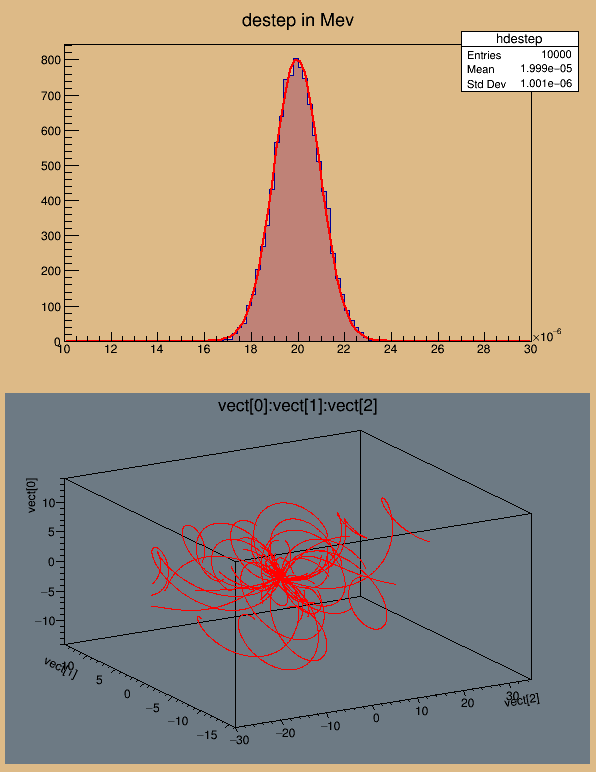

In [6]:
gROOT->GetListOfCanvases()->Draw()